Code for MohammadReza Safari's Thesis
Dataset: STEW
Analyze in 2classes

# Initializer

This code has been run on google colab.

In [ ]:
# 1. mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# 2. set directory of data
%cd /content/gdrive/My Drive/Thesis/dDTF_images
base_dir='/content/gdrive/My Drive/Thesis/dDTF_images/2classes'

freq_band = 'alpha'

# Define the checkpoint filepath for best model
model_checkpoint_filepath = base_dir + '/best_model_2classes_' + freq_band + '_Resnet50LSTM_subject_dependent' + '.h5'
history_dir = base_dir + '/hist_Resnet50LSTM_2classes_SGD_subject_dependent' + freq_band


/content/gdrive/My Drive/Thesis/dDTF_images


In [ ]:
# 3. import libraries

import os
import numpy as np

import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from keras.applications.efficientnet import EfficientNetB0

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer,Dense, Dropout, Input, Activation, TimeDistributed, Reshape
from tensorflow.keras.layers import  GRU, Bidirectional
from tensorflow.keras.layers import  Conv1D, Conv2D, MaxPooling2D, Flatten, BatchNormalization, LSTM, ZeroPadding2D, GlobalAveragePooling2D, SpatialDropout2D, GlobalMaxPool1D,Convolution1D
from tensorflow.keras.callbacks import History
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
import math
import random
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from natsort import natsorted
from tensorflow.keras.models import save_model, load_model
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import cv2
import pickle
from PIL import Image

In [ ]:
# 4. define some methods

def smooth_curve(points, factor=0.2):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

def plot_results(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  %matplotlib inline
  plt.plot(epochs, smooth_curve(acc), 'r', alpha = 0.6, label='Training acc')
  plt.plot(epochs, smooth_curve(val_acc), 'b', alpha = 0.6, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, smooth_curve(loss), 'r', alpha = 0.6, label='Training loss')
  plt.plot(epochs, smooth_curve(val_loss), 'b', alpha = 0.6, label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()


# def plot_mean_of_all_folds(train_acc_list, val_acc_list, train_loss_list, val_loss_list):
#   # Plot the mean of training and validation accuracy across all folds
#   train_acc_mean = np.mean(train_acc_list, axis=0)
#   val_acc_mean = np.mean(val_acc_list, axis=0)
#   train_loss_mean = np.mean(train_loss_list, axis=0)
#   val_loss_mean = np.mean(val_loss_list, axis=0)
#   %matplotlib inline
#   plt.plot(train_acc_mean, 'r', alpha = 0.6, label='Training Accuracy')
#   plt.plot(val_acc_mean, 'b', alpha = 0.6, label='Validation Accuracy')
#   plt.title('Training and validation accuracy')
#   plt.legend()
#   plt.figure()
#   plt.plot(train_loss_mean, 'r', alpha = 0.6, label='Training loss')
#   plt.plot(val_loss_mean, 'b', alpha = 0.6, label='Validation loss')
#   plt.title('Training and validation accuracy')
#   plt.legend()
#   plt.show()


# def calculate_test_accuracy(model, X_test, Y_test):
#   fold_results = {}
#   Y_test = np_utils.to_categorical(Y_test)
#   predicted_probas = model.predict(np.array(X_test),steps = len(X_test))
#   fold_results['predicted_probas'] = predicted_probas
#   maxindex = predicted_probas[i,:].argmax() ##UnboundLocalError: local variable 'i' referenced before assignment
#   binary_prediction=[]
#   binary_prediction0=[]
#   for i in range(len(predicted_probas)):
#      binary_prediction0 = 1 if predicted_probas[i,:].argmax()>=0.5 else 0
#     #  binary_prediction0 = np.round(predicted_probas)
#      binary_prediction.append(binary_prediction0)
#   fold_results['binary_prediction'] = binary_prediction
#   conf_mat = confusion_matrix(binary_prediction, Y_test)
#   fold_results['confusion_matrix'] = conf_mat
#   acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
#   fold_results['test_accuracy'] = acc
#   print('Overall accuracy: {:.2f} %'.format(acc*100))
#   return fold_results

def test_accuracy(model, X_test, Y_test):
  X_test = np.array(X_test)
  Y_test = np.array(Y_test)

  Y_test = np_utils.to_categorical(Y_test)
  Y_pred = model.predict(X_test)
  Y_pred = np.argmax(Y_pred, axis=1)
  Y_test = np.argmax(Y_test, axis=1)
  test_acc = accuracy_score(Y_pred,Y_test)
  cm = confusion_matrix(Y_test, Y_pred)
  plot_conf_mat(cm)

  return test_acc, cm

def plot_conf_mat(cm):
  # Normalize the confusion matrix
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  conf_labels = ['low', 'high']
  sns.heatmap(cm_norm, annot=True, cmap='Blues', fmt='.2%',xticklabels=conf_labels, yticklabels=conf_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


def get_model_metrics(cm):
  TP = cm[0, 0]
  FP = cm[0, 1]
  FN = cm[1, 0]
  TN = cm[1, 1]
  sensitivity = TP / (TP + FN)
  specificity = TN / (TN + FP)
  precision = TP / (TP + FP)
  FAR = FP / (FP + TN)
  FRR = FN / (FN + TP)
  print("Metrics:")
  print(f"Sensitivity: {sensitivity:.2f}")
  print(f"Specificity: {specificity:.2f}")
  print(f"Precision: {precision:.2f}")
  print(f"FAR: {FAR:.2f}")
  print(f"FRR: {FRR:.2f}")

  return sensitivity, specificity, precision, FAR, FRR



def create_model():
  conv_base = ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3)) # include_top=false because we don't want fullyconnected layers.
  # conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
  # conv_base = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

  conv_base.trainable = True

  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten()) # convert output in a array (x,1). voroodi ro migire va saf mikone.
  model.add(layers.Dense(32)) # voroodi ro map mikne roye 32 neuron.

  cnn = models.Model(model.input, model.output) # samte rast daqiqn barabar ba 'model' yani mitonest injori bashe: cnn = model. in dastoore models.Model vase vaqtai khobe ke bekhay be laye hat name bedi va az vasataye model khorooji bgiri daron soorat jaye model.output mizari model.[name]
  # dim of output: [number of input, 32]

  seq_input = Input(shape=(5,224,224,3))

  encoded_sequence = TimeDistributed(cnn)(seq_input) # TimeDistributed miad voroodi ro (5,224,224,3) migire mikne 5 ta (224,224,3) va mide be cnn va result ro dar nahayat concat mikne yani mishe [5, 32] ke in 32 khoroojie modele cnn'e.
  encoded_sequence = Bidirectional(LSTM(32, return_sequences=True))(encoded_sequence) # 32 ta unit dare va chon bidirectionale pas dotarafast pas mishe 64 ta khorooji. return_sequences=true yani kole sequence haye voroodi ro bargardoon pas khorooji mishe [5, 64]
  # encoded_sequence = Dropout(rate=0.1)(encoded_sequence)
  encoded_sequence = Bidirectional(LSTM(32, return_sequences=False))(encoded_sequence) # vaqti return_sequences=false mishe yani faqat akharin unit ro mide pas khorooji mishe: [64]

  out = Dense(2, activation="softmax")(encoded_sequence)
  #out = Convolution1D(1, kernel_size=1, activation="sigmoid", padding="same")(encoded_sequence)
  # out = Dense(1, activation="sigmoid")(encoded_sequence)

  cnn_lstm = models.Model(seq_input, out)
  cnn_lstm.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=1e-4),metrics=['acc'])
  # cnn_lstm.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4),metrics=['acc'])
  # cnn_lstm.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=1e-4),metrics=['acc'])

  if fold_count == 1:
    cnn_lstm.summary()
  return cnn_lstm


# Prepare Data

In [ ]:
# 5. load images data from drive
# In stew dataset each data has 2.5min or 150sec eeg data and we create dDTF images-
# with windowing by size=6sec and step=4sec so 150=6+(n-1)4 --> n=37 images per eeg data

# hi_dir = base_dir + '/' + freq_band + '/hi'
# hi_data = os.listdir(hi_dir)
# hi_data = natsorted(hi_data)
# print(np.array(hi_data).shape)

# lo_dir = base_dir + '/' + freq_band + '/lo'
# lo_data = os.listdir(lo_dir)
# lo_data = natsorted(lo_data)
# print(np.array(lo_data).shape)


(1776,)
(1776,)


In [ ]:
# 6. Resize images. this cell may take some time

# X_q1 = []
# for img in lo_data:
#     with Image.open(lo_dir+"/"+img) as im:
#       resized_im = im.resize((224,224))
#       X_q1.append(resized_im)
# print(np.shape(X_q1))

# X_q2 = []
# for img in hi_data:
#     with Image.open(hi_dir+"/"+img) as im:
#       resized_im = im.resize((224,224))
#       X_q2.append(resized_im)
# print(np.shape(X_q2))

(1776,)
(1776,)


In [ ]:
# 7. create images_data that is a collection from all classes

# Images_data = X_q1 + X_q2 # [lo,hi]


In [ ]:
# 8. dump images_data as Images_data.

# with open(base_dir+'/Images_data_2classes_' + freq_band , 'wb') as file_pi1:
#     pickle.dump(Images_data, file_pi1)


In [ ]:
# 9. load the images_data from drive if you don't wanna run from first cell.

with open(base_dir+'/Images_data_2classes_' + freq_band , 'rb') as f:
    Images_data = pickle.load(f)

print(np.shape(Images_data))


(3552,)


In [ ]:
Images_data = [np.asarray(img) for img in Images_data]

print(type(Images_data[0]));
print(np.shape(Images_data[0]))
print(np.shape(Images_data)) # (3552, 224, 224, 3)


<class 'numpy.ndarray'>
(224, 224, 3)
(3552, 224, 224, 3)


Prepare the video samples

In [ ]:
q1 = 1776*[0]
q2 = 1776*[1]

labels = q1+q2
#labels

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Images_data,labels,test_size=0.1, random_state=6)

In [ ]:
# 11. If you start running from 9th cell you need run this cell to define X_q1 and X_q2

X_q1 = Images_data[:37*48]
X_q2 = Images_data[37*48:]

print(np.shape(X_q1[0]))
print(np.shape(X_q1)) # (1776, 224, 224, 3)
print(np.shape(X_q2))

(224, 224, 3)
(1776, 224, 224, 3)
(1776, 224, 224, 3)


In [ ]:
# 12. create video data of classes

video_q1 = []
subj = 0
stride = 1
init_frame = 0
frame_length = 5 # 5 images per video
for subj in range(48): # number of subjects in class = 'lo'
  for img in range(37): #stride 1/number of images of each subject / / 48 * (37-5+1) = 1584 total video samples per freq. band (ie. gama)
       if img+frame_length>37:
          break
       tmp_video = X_q1[subj*37+img:subj*37+img+frame_length]
       # first 0-5 second 1-6 third 2-7 last 32-37
       # 33 movies for each patient. 33*43 movie in total.
       video_q1.append(tmp_video)

print(np.shape(video_q1)) # The result will be (1584, 5, 224, 224, 3) that is 1584 videos that each of them consist of 5 frames of (224,224,3) images
print(img)


video_q2 = []
subj = 0
stride = 1
init_frame = 0
frame_length = 5
for subj in range(48): # number of subjects
  for img in range(37): #stride 1/number of images of each subject
       if img+frame_length>37:
          break
       tmp_video = X_q2[subj*37+img:subj*37+img+frame_length]
       video_q2.append(tmp_video)

print(np.shape(video_q2)) # (1584, 5, 224, 224, 3)
print(img)


(1584, 5, 224, 224, 3)
33
(1584, 5, 224, 224, 3)
33


In [ ]:
# 14. create video_data that is a collection of all classes and then clear memory

video_data = video_q1 + video_q2
print(np.shape(video_data)) # (3168, 5, 224, 224, 3)


(3168, 5, 224, 224, 3)


In [ ]:
# 15. dump video_classes as video_data

# with open(base_dir+'/video_data_2classes_' + freq_band + '_train', 'wb') as file_pi1:
#     pickle.dump(video_data, file_pi1)

# with open(base_dir+'/video_data_2classes_' + freq_band + '_test', 'wb') as file_pi1:
#     pickle.dump(video_data_test, file_pi1)

In [ ]:
# 16. load video_classes from drive

# with open(base_dir+'/video_data_2classes_' + freq_band + '_train', 'rb') as f:
#     video_data = pickle.load(f)

# print(np.shape(video_data)) # (2838, 5, 224, 224, 3)

# with open(base_dir+'/video_data_2classes_' + freq_band + '_test', 'rb') as f:
#     video_data_test = pickle.load(f)

# print(np.shape(video_data_test)) # (330, 5, 224, 224, 3)

(2838, 5, 224, 224, 3)
(330, 5, 224, 224, 3)


In [ ]:
from sklearn.model_selection import train_test_split
q1 = 1584*[0] #lo
q2 = 1584*[1] #hi
labels = q1 + q2
X_train, X_test, Y_train, Y_test = train_test_split(video_data,labels,test_size=0.1, random_state=8)
print(np.shape(X_train)) # (2851, 5, 224, 224, 3)
print(np.shape(X_test)) # (317, 5, 224, 224, 3)
print(np.shape(Y_train)) # (2851, )
print(np.shape(Y_test)) # (317, )



(2851, 5, 224, 224, 3)
(317, 5, 224, 224, 3)
(2851,)
(317,)


# Splitting data

In [ ]:
# clear memory

q1 = []
q2 = []
q1_test = []
q2_test = []
labels = []
labels_test = []
video_data = []
video_data_test = []
video_q1 = []
video_q2 = []
video_q1_test = []
video_q2_test = []
Images_data = []
Images_data_test = []
X_q1 = []
X_q2 = []
X_q1_test = []
X_q2_test = []

# Create and Fit the model

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 224, 224, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 5, 32)            26799008  
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 64)            16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 2)                 130  

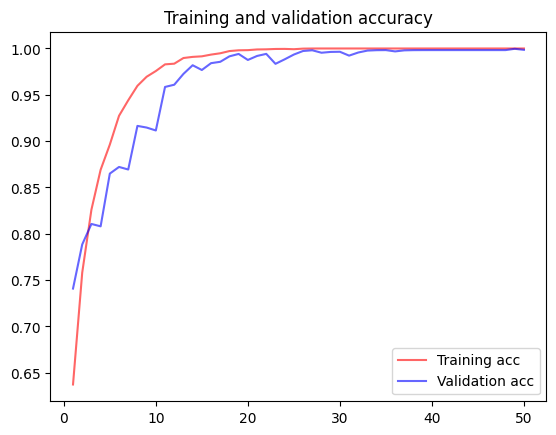

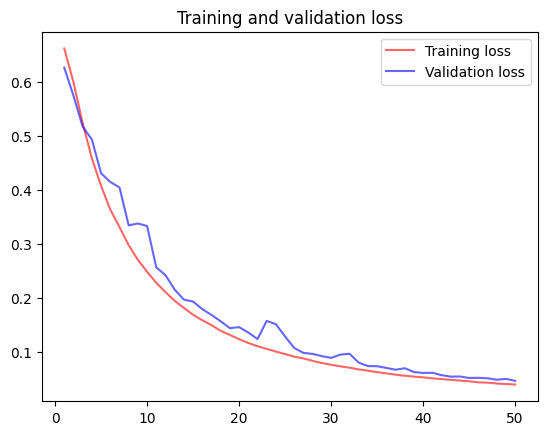

10/10 [==============================] - 16s 945ms/step


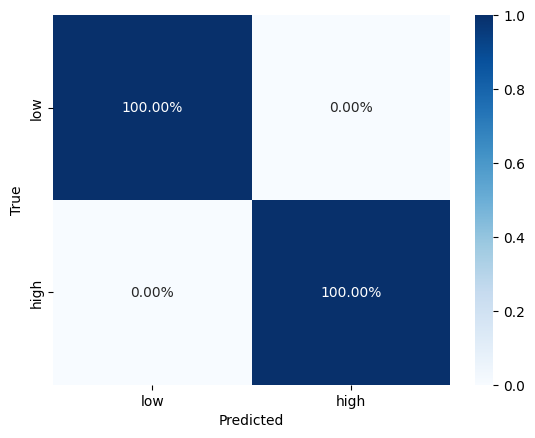

fold_1 test_acc: 1.0
fold_1 confusion matrix: 
[[149   0]
 [  0 168]]

Metrics:
Sensitivity: 1.00
Specificity: 1.00
Precision: 1.00
FAR: 0.00
FRR: 0.00


In [ ]:
# Fit CNN+LSTM model with video data

# Initialize empty lists to store the training and validation accuracy
# train_acc_list = []
# val_acc_list = []
# train_loss_list = []
# val_loss_list = []
fold_count=0
hist = {}
seed = 7
np.random.seed(seed)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)


# Use early stopping to halt the training of the model at the right time based on the validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')


# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


for train_index, val_index in skf.split(X_train,Y_train):
    fold_count = fold_count + 1

    x_train, x_val = np.array(X_train)[train_index], np.array(X_train)[val_index]
    y_train, y_val = np.array(Y_train)[train_index], np.array(Y_train)[val_index]
    y_train = np_utils.to_categorical(y_train)
    y_val = np_utils.to_categorical(y_val)

    model = create_model()

    history = model.fit(
        x_train,y_train,
        epochs=50,
        batch_size=10,  # I got "ResourceExhaustedError: Graph execution error" in batch_size=60
        validation_data = (x_val,y_val),
        shuffle=True,
        callbacks=[early_stopping, checkpoint]
        )

    plot_results(history)

    # Load the best model based on the minimum validation loss
    best_model = load_model(model_checkpoint_filepath)

    test_acc, conf_mat = test_accuracy(best_model, X_test, Y_test) # this model is trained model (after fitting).

    print('fold_'+str(fold_count)+' test_acc: '+str(test_acc))
    print('fold_'+str(fold_count)+' confusion matrix: ')
    print(conf_mat)
    print()

    hist['fold'+str(fold_count)+'_history'] = history.history
    hist['fold'+str(fold_count)+'_results'] = test_acc

    # # save lists of val_acc, acc, val_loss and loss for plotting mean_of_all_folds
    # train_acc_list.append(history.history['acc'])
    # val_acc_list.append(history.history['val_acc'])

    # train_loss_list.append(history.history['loss'])
    # val_loss_list.append(history.history['val_loss'])

    get_model_metrics(conf_mat)

    # save history of each fold
    with open(history_dir + '_fold_'+str(fold_count), 'wb') as file_pi1:
        pickle.dump(hist, file_pi1)

    break
# plot_mean_of_all_folds(train_acc_list, val_acc_list, train_loss_list, val_loss_list)


In [ ]:
# # Load the best model

# model = load_model(model_checkpoint_filepath)

# X_test = np.array(X_test)
# Y_test = np.array(Y_test)

# Y_pred = model.predict(X_train)

In [ ]:
# print(np.shape(Y_pred))

# Y_pred = np.argmax(Y_pred, axis=1) # axis=1 to get the predicted class for each sample

# print(np.shape(Y_pred))
# print(np.shape(Y_train))


(330, 1)
(330,)
(330,)


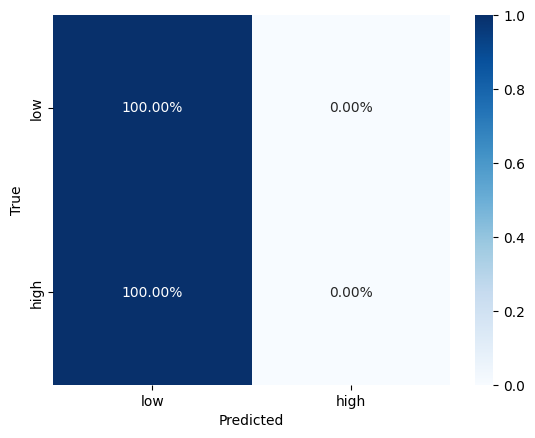

test_acc: 0.5
confusion matrix: 
[[165   0]
 [165   0]]

Metrics:
Sensitivity: 0.50
Specificity: nan
Precision: 1.00
FAR: nan
FRR: 0.50


<ipython-input-17-125798cc66e0>:103: RuntimeWarning: invalid value encountered in long_scalars
  specificity = TN / (TN + FP)
<ipython-input-17-125798cc66e0>:105: RuntimeWarning: invalid value encountered in long_scalars
  FAR = FP / (FP + TN)


(0.5, nan, 1.0, nan, 0.5)

In [ ]:
# test_acc = accuracy_score(Y_train, Y_pred)
# cm = confusion_matrix(Y_test, Y_pred)
# plt.figure()
# plot_conf_mat(cm)

# print('test_acc: ' + str(test_acc))
# print('confusion matrix: ')
# print(conf_mat)
# print()

# get_model_metrics(conf_mat)
